# CNN initial Model for data

## Imports

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy

#%matplotlib inline
%matplotlib widget

import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

try:
    from tqdm import tqdm
except:
    def tqdm(x, *args, **kwargs):
        return x

## Loading Data


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = CIFAR10(root='./data', train=True,
                   download=True, transform=transform)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=0)

valloader = DataLoader(val_dataset, batch_size=batch_size,
                       shuffle=True, num_workers=0)

testset = CIFAR10(root='./data', train=False,
                  download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Defining Model

In [3]:
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()

        self.ConvLayers = nn.ModuleList([
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # N x 3 x 32 x 32 -> N x 32 x 32 x 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # N x 32 x 16 x 16 -> N x 64 x 16 x 16
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # N x 64 x 8 x 8 -> N x 128 x 8 x 8
        ])

        self.BatchNorms = nn.ModuleList([
            nn.BatchNorm2d(32),
            nn.BatchNorm2d(64),
            nn.BatchNorm2d(128),
        ])

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        for conv, batchnorm in zip(self.ConvLayers, self.BatchNorms):
            x = batchnorm(conv(x))
            x = self.pool(self.relu(x))       # final shape: N x 128 x 4 x 4
        x = x.view(x.size(0), -1)                   # reshape to N x 128*4*4
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
net = SmallCNN().to(device)

trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)

weights = copy.deepcopy(net.state_dict())

device: cuda:0
Trainable parameters: 620810


In [32]:
def init_weights_(m, init_method):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:

        if init_method == "xavier_uniform":
            nn.init.xavier_uniform_(m.weight)
        elif init_method == "xavier_normal":
            nn.init.xavier_normal_(m.weight)
        elif init_method == "uniform":
            nn.init.uniform_(m.weight, -0.1, 0.1)
        elif init_method == "normal":
            nn.init.normal_(m.weight, mean=0, std=1.)
        elif init_method == "kaiming_uniform":
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') 
        elif init_method == "kaiming_normal":
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu') 

def init_weights_constant_(m, constant):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        nn.init.constant_(m.weight, constant)

def perturb_weights_(m, delta):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        std = m.weight.std().item()
        m.weight.data += delta * std

## Training the network

In [6]:
criterion = nn.CrossEntropyLoss()

In [ ]:

EPOCHS = 30

#weight_inits = [lambda m: init_weights_(m, "kaiming_normal"), lambda m_: init_weights_(m_, "kaiming_uniform")]
weight_inits = [None] * 2

model_weights = []

for i, init in enumerate(weight_inits):

    #writer = SummaryWriter(comment=f"265_neurons_02_dropout_model_{i+1}")  # TENSORBOARD

    net = SmallCNN().to(device)
    #net.load_state_dict(weights)
    #net.apply(init)

    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    training_loss = []
    val_accuracy = []

    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        for i, (input, labels) in enumerate(trainloader):
            # -- get the inputs; data is a list of [inputs, labels]
            inputs, labels = input.to(device), labels.to(device)

            # -- zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # -- print statistics
            running_loss += loss.item()
        
        #writer.add_scalar("Batch_Loss/train", running_loss / len(trainloader), epoch)   # TENSORBOARD
        training_loss.append(running_loss / len(trainloader))

        if epoch % 1 == 0:
            net.eval()

            correct = 0
            total = 0

            with torch.no_grad():
                for (images, labels) in valloader:
                    images, labels = images.to(device), labels.to(device)
                    # -- calculate outputs by running images through the network
                    outputs = net(images)
                    # -- the class with the highest energy is what we choose as prediction
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            epoch_accuracy = 100 * correct // total
            val_accuracy.append(epoch_accuracy)
            print(f"Epoch {epoch+1}/{EPOCHS},\n  Train loss: {training_loss[epoch]},\n  Validation Accuracy: {epoch_accuracy}%")
            #writer.add_scalar("Validation_Accuracy", epoch_accuracy, epoch)        # TENSORBOARD

    #writer.flush()     # TENSORBOARD
    #writer.close()     # TENSORBOARD
    
    model_weights.append(copy.deepcopy(net.state_dict()))

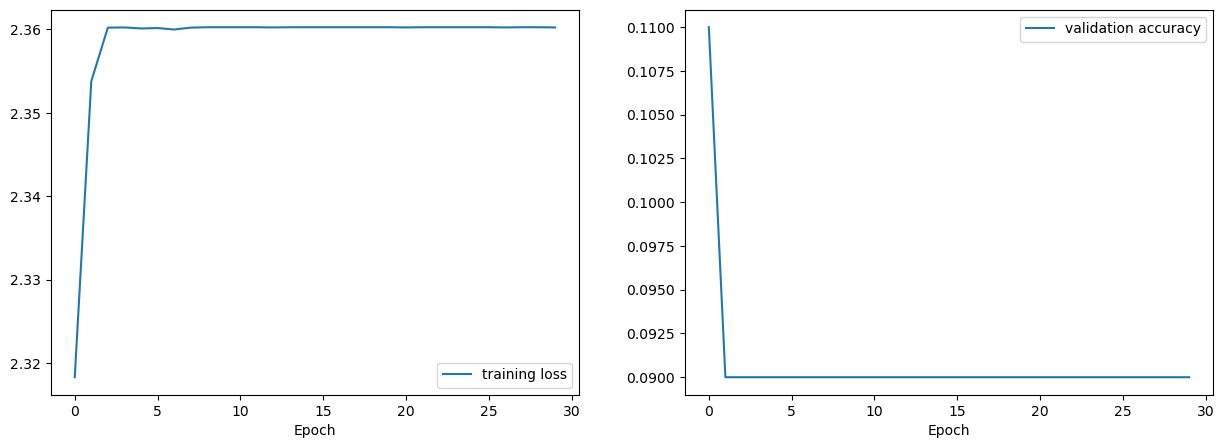

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(np.arange(EPOCHS), training_loss, label="training loss")
axs[1].plot(np.arange(EPOCHS), np.array(val_accuracy) / 100, label="validation accuracy")

for ax in axs:
    ax.set_xlabel("Epoch")
    ax.legend()
plt.show()

In [7]:
def interpolate_state_dict(state_dict_a, state_dict_b, alpha):
    """Interpolate between state_dict_a and state_dict_b.
    
    Args:
        state_dict_a (dict): Model state dictionary from minimum A.
        state_dict_b (dict): Model state dictionary from minimum B.
        alpha (float): Interpolation factor (0.0 -> state_dict_a, 1.0 -> state_dict_b).
        
    Returns:
        dict: Interpolated state dictionary.
    """
    interpolated_state = {}
    for key in state_dict_a.keys():
        interpolated_state[key] = (1 - alpha) * state_dict_a[key] + alpha * state_dict_b[key]
    return interpolated_state


def calculate_loss(model, dataloader, criterion, device):
    '''
    calculate the loss of the model on the dataset
    '''
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (input, labels) in enumerate(dataloader):
            inputs, labels = input.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(dataloader)

In [9]:
model_weights = []
model_weights.append(torch.load("data/models/interp1.pth"))
model_weights.append(torch.load("data/models/interp2.pth"))

alphas = np.linspace(0, 1, 50)
interp_losses = []

interp_net = SmallCNN().to(device)
for alpha in alphas:
    interp_state = interpolate_state_dict(model_weights[0], model_weights[1], alpha)
    interp_net.load_state_dict(interp_state)
    loss = calculate_loss(interp_net, testloader, criterion, device)
    interp_losses.append(loss)

0
0


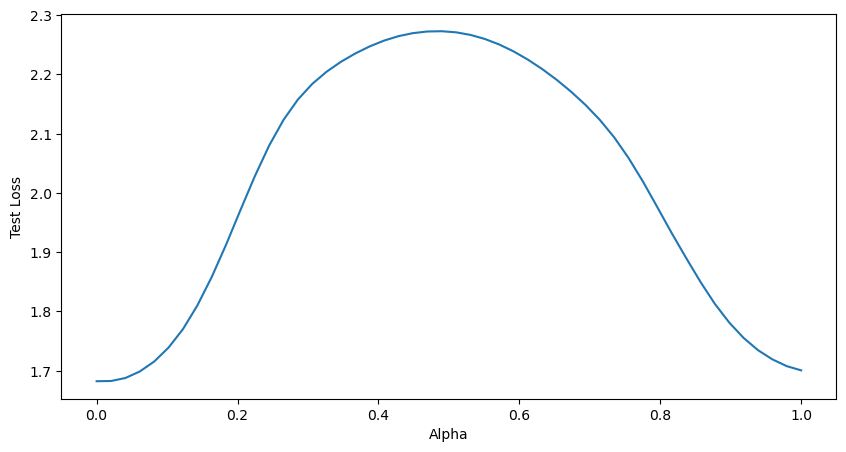

In [20]:
%matplotlib inline
interp_losses = np.array(interp_losses)
print(np.isnan(interp_losses).sum())
print(np.isinf(interp_losses).sum())

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(alphas, interp_losses)
ax.set_xlabel("Alpha")
ax.set_ylabel("Test Loss")
plt.show()

In [41]:
# Helper function to flatten model parameters into a single vector.
def get_flat_params(model):
    return torch.cat([p.view(-1) for p in model.parameters() if p.requires_grad])

# Helper function to set the model's parameters from a flat vector.
def set_flat_params(model, flat_params):
    offset = 0
    for p in model.parameters():
        if p.requires_grad:
            numel = p.numel()
            new_val = flat_params[offset: offset + numel].view_as(p)
            p.data.copy_(new_val)
            offset += numel

# Generate two random orthonormal directions in weight space.
def get_random_directions(model, scale=1e-2):
    flat_params = get_flat_params(model)
    dir1 = torch.randn_like(flat_params)
    dir2 = torch.randn_like(flat_params)
    # Orthogonalize dir2 with respect to dir1.
    dir2 -= (torch.dot(dir1, dir2) / torch.dot(dir1, dir1)) * dir1
    # Normalize and scale directions.
    dir1 = scale * dir1 / dir1.norm()
    dir2 = scale * dir2 / dir2.norm()
    return dir1, dir2

net = SmallCNN().to(device)
net.load_state_dict(model_weights[0])

baseline = get_flat_params(net)
dir1, dir2 = get_random_directions(net)

# Create a grid over the 2D plane.
alphas = np.linspace(-2, 2, 20)
betas = np.linspace(-2, 2, 20)
loss_values = np.zeros((len(alphas), len(betas)))

for i, alpha in tqdm(enumerate(alphas)):
    for j, beta in enumerate(betas):
        # Create a new set of weights in the 2D plane.
        new_params = baseline + alpha * dir1 + beta * dir2
        set_flat_params(net, new_params)
        loss_values[i, j] = calculate_loss(net, testloader, criterion, device)

In [11]:
# Plotting the loss landscape.
SAVE_DATA = False


if SAVE_DATA:
    X, Y = np.meshgrid(betas, alphas)  # Note: axes order might vary.
    plot_dict = {
        "X": X,
        "Y": Y,
        "Z": loss_values
    }
    np.savez("data/plot_dict.npz", **plot_dict)
else:
    plot_dict = np.load("data/plot_dict.npz")
    X, Y, loss_values = plot_dict["X"], plot_dict["Y"], plot_dict["Z"]

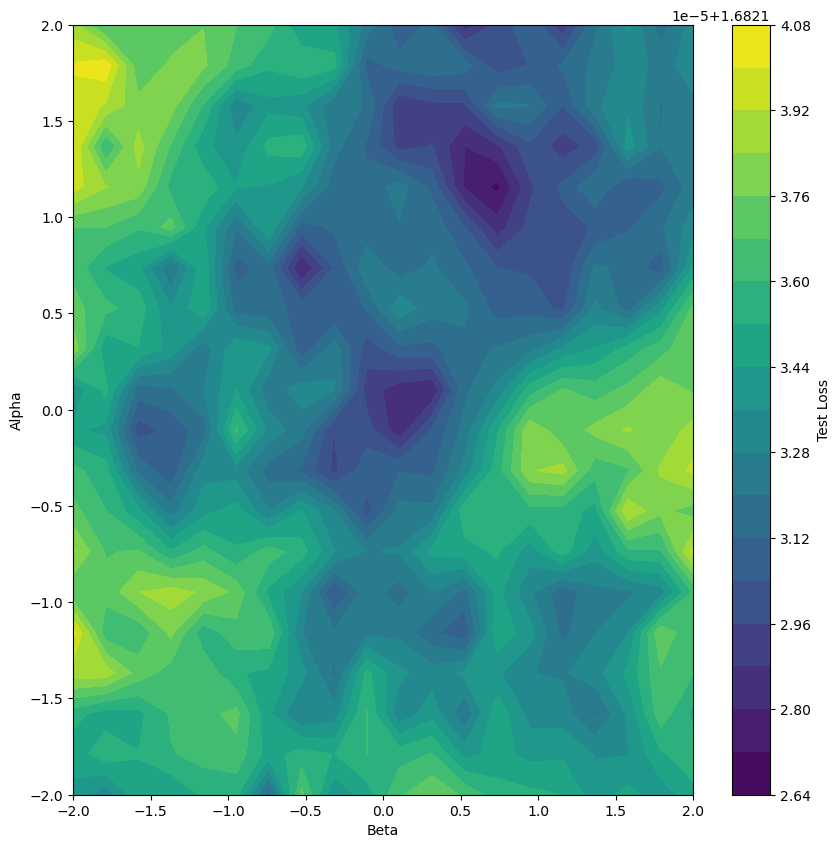

In [27]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))
cplot = ax.contourf(X, Y, loss_values, levels=20)
ax.set_xlabel("Beta")
ax.set_ylabel("Alpha")
fig.colorbar(cplot, ax=ax, label="Test Loss")
plt.show()

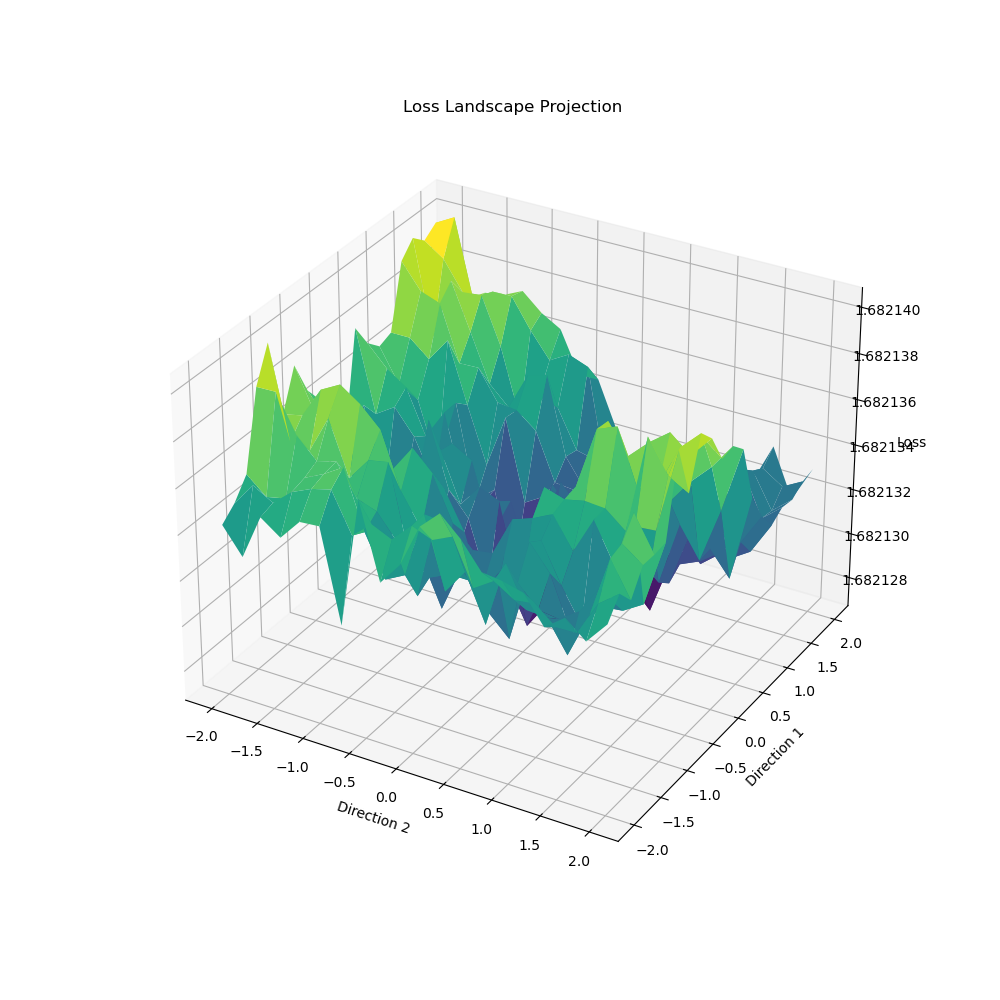

In [21]:
import matplotlib.ticker as ticker
%matplotlib widget

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, loss_values, cmap='viridis')
ax.set_xlabel('Direction 2')
ax.set_ylabel('Direction 1')
ax.set_zlabel('Loss')
ax.set_title("Loss Landscape Projection")

formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)
ax.zaxis.set_major_formatter(formatter)
plt.show()